In [25]:
# Cell 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D, Input, 
    SeparableConv2D, Add, Activation, SpatialDropout2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")

TensorFlow Version: 2.20.0
NumPy Version: 2.2.6


In [26]:
# Cell 2: Check Current Directory and Create Dataset Structure
import os

# Check current directory
print("Current working directory:", os.getcwd())
print("\nFiles in current directory:")
print(os.listdir('.'))

# Create Dataset directory structure
def create_dataset_structure():
    """Create the basic dataset structure"""
    
    base_dir = 'Dataset'
    subdirs = ['Tuberculosis', 'Normal', 'Train', 'Validation', 'Test']
    
    for subdir in subdirs:
        path = os.path.join(base_dir, subdir)
        os.makedirs(path, exist_ok=True)
        print(f"Created directory: {path}")
    
    # Create subdirectories inside Train, Validation, Test
    for split in ['Train', 'Validation', 'Test']:
        for class_name in ['Tuberculosis', 'Normal']:
            path = os.path.join(base_dir, split, class_name)
            os.makedirs(path, exist_ok=True)
            print(f"Created directory: {path}")
    
    print("\nDataset structure created successfully!")
    return base_dir

# Create dataset structure
base_dir = create_dataset_structure()

Current working directory: d:\

Files in current directory:
['$RECYCLE.BIN', 'A Dance of Fire and Ice', 'AOL Sinefolis', 'Babie', 'best_tbnet_model.h5', 'Dataset', 'Dataset - Copy (1).zip', 'DumpStack.log.tmp', 'Epic Games', 'Graphviz-14.1.0-win64', 'HoYoPlay', 'Jacelyn Document', 'model ai', 'osu!', 'PlateUp!', 'Riot Games', 'sample_test_xray.jpg', 'scicomp', 'SteamLibrary', 'System Volume Information', 'Tb-net.ipynb', 'tbnet_output', 'TeknoParrot_1.0.0.140', 'WMMT6']
Created directory: Dataset\Tuberculosis
Created directory: Dataset\Normal
Created directory: Dataset\Train
Created directory: Dataset\Validation
Created directory: Dataset\Test
Created directory: Dataset\Train\Tuberculosis
Created directory: Dataset\Train\Normal
Created directory: Dataset\Validation\Tuberculosis
Created directory: Dataset\Validation\Normal
Created directory: Dataset\Test\Tuberculosis
Created directory: Dataset\Test\Normal

Dataset structure created successfully!


In [27]:
# Cell 3: Option 1 - Upload Dataset (for Google Colab/Local)
def upload_dataset_option():
    """Provide options for dataset upload"""
    
    print("Please choose one of the following options:")
    print("1. I have images in Dataset/Tuberculosis and Dataset/Normal folders")
    print("2. I want to create a sample dataset for testing")
    print("3. I'm using Google Colab and need to upload files")
    
    choice = input("Enter your choice (1, 2, or 3): ")
    
    if choice == "1":
        print("Great! Make sure you have images in:")
        print("- Dataset/Tuberculosis/ (TB X-ray images)")
        print("- Dataset/Normal/ (Normal X-ray images)")
        
        # Check if images exist
        tb_dir = os.path.join('Dataset', 'Tuberculosis')
        normal_dir = os.path.join('Dataset', 'Normal')
        
        if os.path.exists(tb_dir) and os.path.exists(normal_dir):
            tb_files = [f for f in os.listdir(tb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            normal_files = [f for f in os.listdir(normal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"\nFound {len(tb_files)} Tuberculosis images")
            print(f"Found {len(normal_files)} Normal images")
            
            if len(tb_files) > 0 and len(normal_files) > 0:
                return True
            else:
                print("WARNING: No images found in the directories!")
                return False
        else:
            print("WARNING: Directories not found!")
            return False
            
    elif choice == "2":
        print("\nCreating a sample dataset with synthetic data for testing...")
        create_sample_dataset()
        return True
        
    elif choice == "3":
        print("\nPlease upload your dataset files.")
        print("In Google Colab, use: from google.colab import files")
        print("Then run: uploaded = files.upload()")
        print("After uploading, organize them into Dataset/Tuberculosis/ and Dataset/Normal/")
        return False
        
    else:
        print("Invalid choice. Please run this cell again.")
        return False

def create_sample_dataset():
    """Create a small sample dataset for testing"""
    
    import numpy as np
    from PIL import Image
    import random
    
    print("Creating sample dataset...")
    
    # Create some synthetic X-ray like images
    def create_synthetic_xray(label, idx):
        """Create synthetic X-ray image"""
        img_size = (224, 224)
        
        # Base image (simulating X-ray)
        img = np.random.randn(img_size[0], img_size[1]) * 0.1 + 0.5
        
        if label == "Tuberculosis":
            # Add some "abnormalities" for TB
            for _ in range(random.randint(3, 10)):
                x = random.randint(50, 174)
                y = random.randint(50, 174)
                size = random.randint(10, 30)
                img[y:y+size, x:x+size] += np.random.randn(size, size) * 0.3
        
        # Normalize to 0-255
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        
        return Image.fromarray(img)
    
    # Create directories
    base_dir = 'Dataset'
    os.makedirs(os.path.join(base_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'Normal'), exist_ok=True)
    
    # Create 10 sample images for each class
    for label in ['Tuberculosis', 'Normal']:
        for i in range(10):
            img = create_synthetic_xray(label, i)
            filename = f"{label.lower()}_{i+1:03d}.png"
            filepath = os.path.join(base_dir, label, filename)
            img.save(filepath)
            print(f"Created: {filepath}")
    
    print("\nSample dataset created with 10 images per class.")
    print("These are synthetic images for testing purposes only.")

# Check dataset
has_dataset = upload_dataset_option()

Please choose one of the following options:
1. I have images in Dataset/Tuberculosis and Dataset/Normal folders
2. I want to create a sample dataset for testing
3. I'm using Google Colab and need to upload files
Great! Make sure you have images in:
- Dataset/Tuberculosis/ (TB X-ray images)
- Dataset/Normal/ (Normal X-ray images)

Found 2500 Tuberculosis images
Found 2500 Normal images


In [28]:
# Cell 4: Dataset Preparation Function (Fixed)
def prepare_dataset(data_dir='Dataset'):
    """Prepare and split dataset into Train/Validation/Test"""
    
    print(f"Preparing dataset from: {data_dir}")
    
    tb_dir = os.path.join(data_dir, 'Tuberculosis')
    normal_dir = os.path.join(data_dir, 'Normal')
    
    # Check if directories exist
    if not os.path.exists(tb_dir):
        print(f"ERROR: Directory not found: {tb_dir}")
        print("Please make sure you have Tuberculosis images in Dataset/Tuberculosis/")
        return None
    
    if not os.path.exists(normal_dir):
        print(f"ERROR: Directory not found: {normal_dir}")
        print("Please make sure you have Normal images in Dataset/Normal/")
        return None
    
    # Get file paths
    try:
        tb_files = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Found {len(tb_files)} Tuberculosis images")
        print(f"Found {len(normal_files)} Normal images")
        
        if len(tb_files) == 0 or len(normal_files) == 0:
            print("ERROR: No images found in one or both directories!")
            return None
            
    except Exception as e:
        print(f"ERROR reading directories: {e}")
        return None
    
    # Create labels
    tb_labels = [1] * len(tb_files)  # 1 for Tuberculosis
    normal_labels = [0] * len(normal_files)  # 0 for Normal
    
    # Combine
    all_files = tb_files + normal_files
    all_labels = tb_labels + normal_labels
    
    # Split: Train (70%), Val (15%), Test (15%)
    try:
        train_files, temp_files, train_labels, temp_labels = train_test_split(
            all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        
        val_files, test_files, val_labels, test_labels = train_test_split(
            temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
        )
        
        print(f"\nSplit successful!")
        print(f"  Train: {len(train_files)} images")
        print(f"  Validation: {len(val_files)} images")
        print(f"  Test: {len(test_files)} images")
        
    except Exception as e:
        print(f"ERROR during train-test split: {e}")
        return None
    
    # Create directory structure for splits
    splits = {
        'Train': (train_files, train_labels),
        'Validation': (val_files, val_labels),
        'Test': (test_files, test_labels)
    }
    
    # Create directories
    for split_name in splits.keys():
        split_dir = os.path.join(data_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in ['Tuberculosis', 'Normal']:
            class_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
    
    # Copy files to respective directories
    def copy_files(files_list, labels_list, destination):
        copied = 0
        for file_path, label in zip(files_list, labels_list):
            try:
                class_name = 'Tuberculosis' if label == 1 else 'Normal'
                dest_path = os.path.join(destination, class_name, os.path.basename(file_path))
                shutil.copy2(file_path, dest_path)
                copied += 1
            except Exception as e:
                print(f"Warning: Could not copy {file_path}: {e}")
        return copied
    
    # Copy files for each split
    print("\nCopying files to split directories...")
    for split_name, (files, labels) in splits.items():
        dest_dir = os.path.join(data_dir, split_name)
        copied = copy_files(files, labels, dest_dir)
        print(f"  {split_name}: Copied {copied}/{len(files)} files")
    
    # Verify the splits
    print("\nVerifying split directories...")
    for split_name in ['Train', 'Validation', 'Test']:
        split_dir = os.path.join(data_dir, split_name)
        tb_count = len([f for f in os.listdir(os.path.join(split_dir, 'Tuberculosis')) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        normal_count = len([f for f in os.listdir(os.path.join(split_dir, 'Normal')) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {split_name}: {tb_count} TB, {normal_count} Normal")
    
    return {
        'train_dir': os.path.join(data_dir, 'Train'),
        'val_dir': os.path.join(data_dir, 'Validation'),
        'test_dir': os.path.join(data_dir, 'Test'),
        'stats': {
            'total_images': len(all_files),
            'tb_count': len(tb_files),
            'normal_count': len(normal_files),
            'train_count': len(train_files),
            'val_count': len(val_files),
            'test_count': len(test_files)
        }
    }

# Run dataset preparation
dataset_paths = prepare_dataset()

if dataset_paths:
    print("\n✓ Dataset prepared successfully!")
    print(f"Train directory: {dataset_paths['train_dir']}")
    print(f"Validation directory: {dataset_paths['val_dir']}")
    print(f"Test directory: {dataset_paths['test_dir']}")
else:
    print("\n✗ Dataset preparation failed. Please check your dataset structure.")

Preparing dataset from: Dataset
Found 2500 Tuberculosis images
Found 2500 Normal images

Split successful!
  Train: 3500 images
  Validation: 750 images
  Test: 750 images

Copying files to split directories...
  Train: Copied 3500/3500 files
  Validation: Copied 750/750 files
  Test: Copied 750/750 files

Verifying split directories...
  Train: 1750 TB, 1750 Normal
  Validation: 375 TB, 375 Normal
  Test: 375 TB, 375 Normal

✓ Dataset prepared successfully!
Train directory: Dataset\Train
Validation directory: Dataset\Validation
Test directory: Dataset\Test


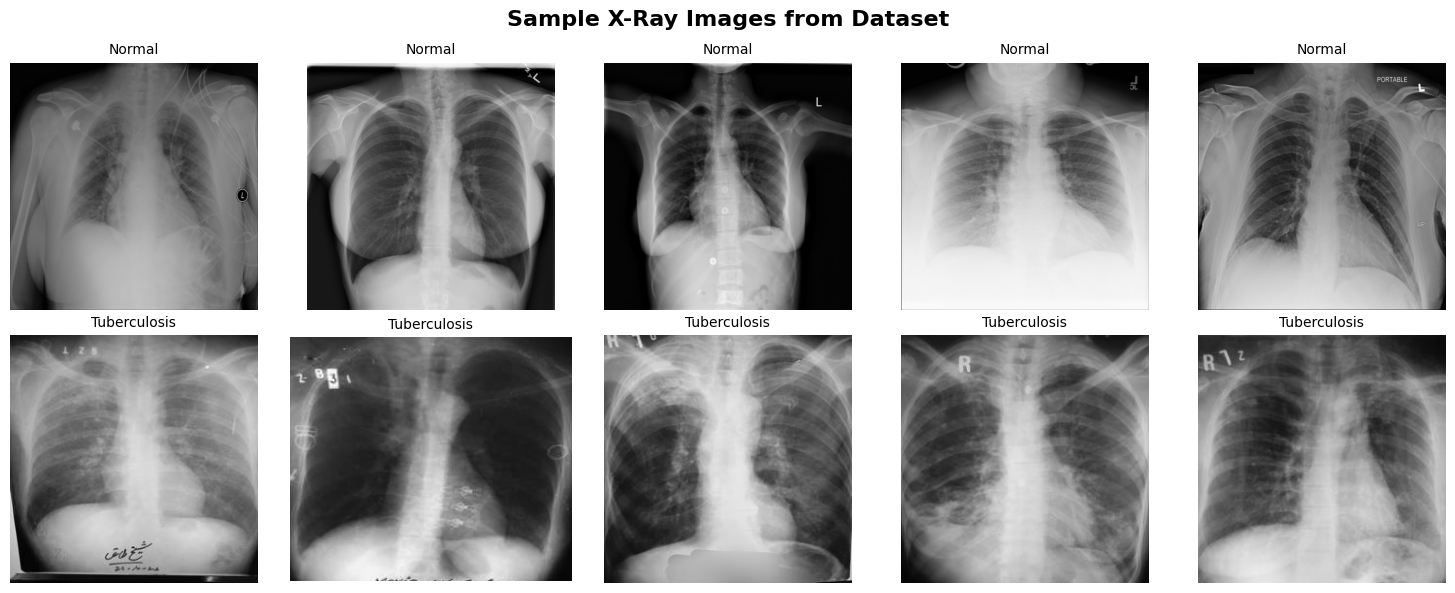


📊 Dataset Statistics:
   Total Images: 5000
   Tuberculosis: 2500
   Normal: 2500
   Train set: 3500
   Validation set: 750
   Test set: 750


In [29]:
# Cell 5: Data Visualization (Updated)
def visualize_dataset(dataset_paths):
    """Visualize sample images from dataset"""
    
    if not dataset_paths:
        print("No dataset paths provided")
        return
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample X-Ray Images from Dataset', fontsize=16, fontweight='bold')
    
    classes = ['Normal', 'Tuberculosis']
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_paths['train_dir'], class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue
        
        # Get image files
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if len(images) == 0:
            print(f"Warning: No images found in {class_dir}")
            continue
        
        # Take up to 5 images
        images = images[:5]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = plt.imread(img_path)
                
                # If grayscale, convert to RGB for consistent display
                if len(img.shape) == 2:
                    img = np.stack([img]*3, axis=-1)
                
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].set_title(f'{class_name}', fontsize=10)
                axes[i, j].axis('off')
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print dataset statistics
    if 'stats' in dataset_paths:
        stats = dataset_paths['stats']
        print(f"\n📊 Dataset Statistics:")
        print(f"   Total Images: {stats['total_images']}")
        print(f"   Tuberculosis: {stats['tb_count']}")
        print(f"   Normal: {stats['normal_count']}")
        print(f"   Train set: {stats['train_count']}")
        print(f"   Validation set: {stats['val_count']}")
        print(f"   Test set: {stats['test_count']}")

# Visualize dataset
visualize_dataset(dataset_paths)

In [30]:
# Cell 6: TB-Net Architecture
def build_tbnet_lite(input_shape=(224, 224, 3)):
    """TB-Net Lite: Simple and stable architecture"""
    
    print(f"Building TB-Net Lite with input shape: {input_shape}")
    
    model = Sequential([
        # Input normalization
        tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
        
        # Block 1 - Feature extraction
        Conv2D(32, (7, 7), strides=2, padding='same', 
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((3, 3), strides=2, padding='same'),
        SpatialDropout2D(0.1),
        
        # Block 2
        SeparableConv2D(64, (3, 3), padding='same',
                       depthwise_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        SpatialDropout2D(0.2),
        
        # Block 3
        SeparableConv2D(128, (3, 3), padding='same',
                       depthwise_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        SpatialDropout2D(0.3),
        
        # Block 4
        SeparableConv2D(256, (3, 3), padding='same',
                       depthwise_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        SeparableConv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        SpatialDropout2D(0.4),
        
        # Global Pooling
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        # Classifier Head
        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid', name='output')
    ], name='TB_Net_Lite')
    
    return model

# Build and display model
tbnet_model = build_tbnet_lite()

# Display model summary
print("\n" + "="*60)
print("MODEL ARCHITECTURE SUMMARY")
print("="*60)
tbnet_model.summary()

# Visualize model architecture
try:
    tf.keras.utils.plot_model(
        tbnet_model,
        to_file='tbnet_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        show_layer_activations=True,
        dpi=96
    )
    print("\n✓ Model architecture saved as 'tbnet_architecture.png'")
except Exception as e:
    print(f"\nNote: Could not save model plot: {e}")

Building TB-Net Lite with input shape: (224, 224, 3)

MODEL ARCHITECTURE SUMMARY


Model: "TB_Net_Lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 56, 56, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_12             │ (None, 56, 56, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_13             │ (None, 56, 56, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 28, 28, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_14             │ (None, 28, 28, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_15             │ (None, 28, 28, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 244,257 (954.13 KB)

 Trainable params: 241,889 (944.88 KB)

 Non-trainable params: 2,368 (9.25 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.

✓ Model architecture saved as 'tbnet_architecture.png'


In [31]:
# Cell 7: Create Data Generators
def create_data_generators(train_dir, val_dir, test_dir, batch_size=32, img_size=(224, 224)):
    """Create data generators with augmentation"""
    
    print("Creating data generators...")
    
    # Training data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )
    
    # Validation and test (no augmentation, just rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    print(f"Training directory: {train_dir}")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        color_mode='rgb',
        seed=42
    )
    
    print(f"Validation directory: {val_dir}")
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        color_mode='rgb'
    )
    
    print(f"Test directory: {test_dir}")
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        color_mode='rgb'
    )
    
    # Print class indices and sample counts
    print(f"\nClass indices: {train_generator.class_indices}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    
    return train_generator, val_generator, test_generator

# Check if dataset_paths exists
if dataset_paths:
    # Create data generators
    train_gen, val_gen, test_gen = create_data_generators(
        dataset_paths['train_dir'],
        dataset_paths['val_dir'],
        dataset_paths['test_dir'],
        batch_size=32
    )
else:
    print("ERROR: Dataset not prepared. Please run Cell 4 first.")
    train_gen, val_gen, test_gen = None, None, None

Creating data generators...
Training directory: Dataset\Train
Found 3500 images belonging to 2 classes.
Validation directory: Dataset\Validation
Found 750 images belonging to 2 classes.
Test directory: Dataset\Test
Found 750 images belonging to 2 classes.

Class indices: {'Normal': 0, 'Tuberculosis': 1}
Training samples: 3500
Validation samples: 750
Test samples: 750


In [32]:
# Cell 8: Compile TB-Net Model
def compile_tbnet_model(model):
    """Compile TB-Net model with appropriate settings"""
    
    print("Compiling TB-Net model...")
    
    # Optimizer with learning rate scheduling
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0
    )
    
    # Define comprehensive metrics
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn')
    ]
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )
    
    print("✓ Model compiled successfully!")
    
    return model

# Compile the model
tbnet_model = compile_tbnet_model(tbnet_model)

Compiling TB-Net model...
✓ Model compiled successfully!


In [33]:
# Cell 9: Setup Callbacks (Fixed)
def setup_callbacks():
    """Setup training callbacks"""
    
    print("Setting up training callbacks...")
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_auc',
            patience=15,
            restore_best_weights=True,
            mode='max',
            verbose=1,
            min_delta=0.001
        ),
        
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save the best model
        ModelCheckpoint(
            'best_tbnet_model.keras',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    
    print("✓ Callbacks setup completed")
    return callbacks

callbacks = setup_callbacks()

Setting up training callbacks...
✓ Callbacks setup completed


In [34]:
# Cell 10: Calculate Class Weights
def calculate_class_weights(train_generator):
    """Calculate class weights for imbalanced dataset"""
    
    if train_generator is None:
        print("ERROR: Train generator not available")
        return None
    
    print("Calculating class weights...")
    
    try:
        # Get class distribution
        class_counts = np.bincount(train_generator.classes)
        total_samples = len(train_generator.classes)
        
        print(f"Class distribution:")
        print(f"  Class 0 (Normal): {class_counts[0]} samples ({class_counts[0]/total_samples:.1%})")
        print(f"  Class 1 (Tuberculosis): {class_counts[1]} samples ({class_counts[1]/total_samples:.1%})")
        
        # Calculate class weights
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_generator.classes),
            y=train_generator.classes
        )
        
        class_weights_dict = dict(enumerate(class_weights))
        print(f"\nClass weights: {class_weights_dict}")
        
        return class_weights_dict
        
    except Exception as e:
        print(f"Error calculating class weights: {e}")
        return None

# Calculate class weights
if train_gen is not None:
    class_weights_dict = calculate_class_weights(train_gen)
else:
    class_weights_dict = None
    print("Skipping class weight calculation (no train generator)")

Calculating class weights...
Class distribution:
  Class 0 (Normal): 1750 samples (50.0%)
  Class 1 (Tuberculosis): 1750 samples (50.0%)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [35]:
# Cell 11: Model Training
def train_model(model, train_gen, val_gen, epochs=50, callbacks=None, class_weights=None):
    """Train the TB-Net model"""
    
    print("\n" + "="*60)
    print("STARTING MODEL TRAINING")
    print("="*60)
    
    if train_gen is None or val_gen is None:
        print("ERROR: Data generators not available")
        return None
    
    # Calculate steps
    train_steps = len(train_gen)
    val_steps = len(val_gen)
    
    print(f"\nTraining Configuration:")
    print(f"  Training samples: {train_gen.samples}")
    print(f"  Validation samples: {val_gen.samples}")
    print(f"  Batch size: {train_gen.batch_size}")
    print(f"  Train steps per epoch: {train_steps}")
    print(f"  Validation steps per epoch: {val_steps}")
    print(f"  Total epochs: {epochs}")
    print(f"  Class weights: {class_weights}")
    
    print(f"\nModel will be saved as:")
    print(f"  - 'best_tbnet_model.keras' (best model)")
    print(f"  - 'tbnet_epoch_XX.keras' (every 5 epochs)")
    
    # Train the model
    print("\nTraining started...")
    print("-" * 60)
    
    try:
        history = model.fit(
            train_gen,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        print("\n✓ Training completed successfully!")
        return history
        
    except Exception as e:
        print(f"\n✗ Training failed: {e}")
        return None

# Train the model
if train_gen is not None and val_gen is not None:
    history = train_model(
        tbnet_model,
        train_gen,
        val_gen,
        epochs=30,  # Reduced for faster training
        callbacks=callbacks,
        class_weights=class_weights_dict
    )
else:
    print("Skipping training (data generators not available)")
    history = None


STARTING MODEL TRAINING

Training Configuration:
  Training samples: 3500
  Validation samples: 750
  Batch size: 32
  Train steps per epoch: 110
  Validation steps per epoch: 24
  Total epochs: 30
  Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Model will be saved as:
  - 'best_tbnet_model.keras' (best model)
  - 'tbnet_epoch_XX.keras' (every 5 epochs)

Training started...
------------------------------------------------------------
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.5189 - auc: 0.5385 - fn: 370.2818 - fp: 470.5273 - loss: 0.9389 - precision: 0.5172 - recall: 0.5957 - tn: 417.1909 - tp: 515.2727
Epoch 1: val_auc improved from None to 0.50000, saving model to best_tbnet_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 99s 847ms/step - accuracy: 0.5317 - auc: 0.5548 - fn: 761.0000 - fp: 878.0000 - loss: 0.8957 - precision: 0.5297 - recall: 0.5651 - tn: 872.0000 - tp: 989.0000 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 375

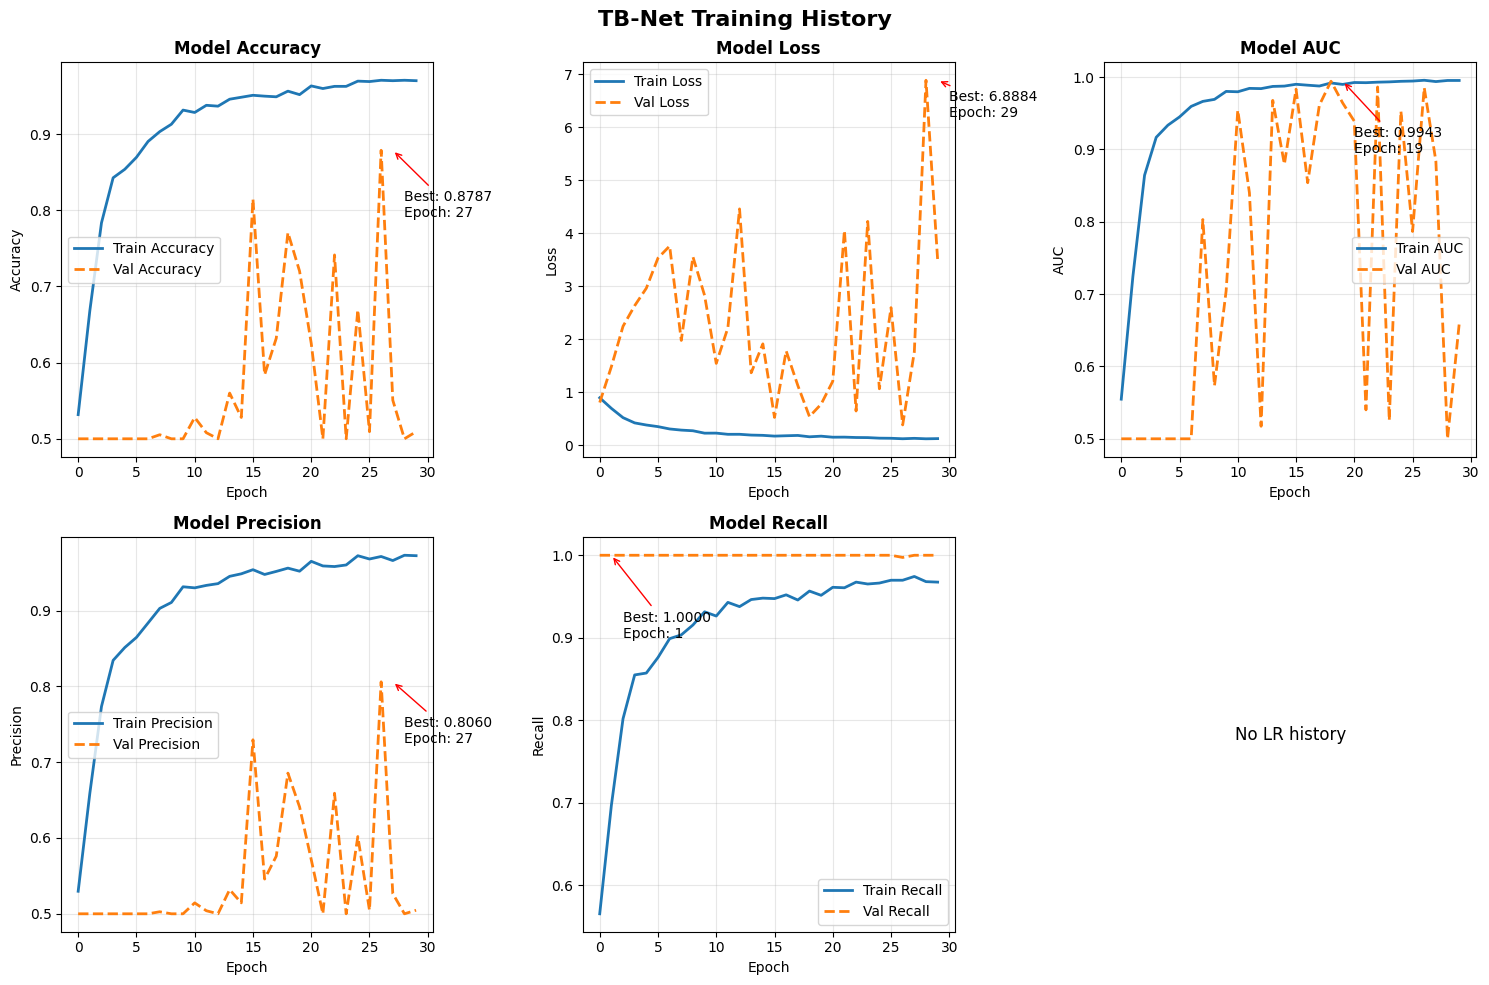


FINAL TRAINING METRICS
Accuracy     Train: 0.9700 | Val: 0.5093
Loss         Train: 0.1254 | Val: 3.5018
Auc          Train: 0.9954 | Val: 0.6587
Precision    Train: 0.9724 | Val: 0.5047
Recall       Train: 0.9674 | Val: 1.0000


In [36]:
# Cell 12: Training Visualization
def plot_training_history(history):
    """Plot training history metrics"""
    
    if history is None:
        print("No training history available")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot configuration
    metrics_config = [
        ('accuracy', 'val_accuracy', 'Accuracy', 0),
        ('loss', 'val_loss', 'Loss', 1),
        ('auc', 'val_auc', 'AUC', 2),
        ('precision', 'val_precision', 'Precision', 3),
        ('recall', 'val_recall', 'Recall', 4)
    ]
    
    for train_metric, val_metric, title, idx in metrics_config:
        row, col = divmod(idx, 3)
        
        if train_metric in history.history:
            axes[row, col].plot(history.history[train_metric], 
                               label=f'Train {title}', linewidth=2)
            axes[row, col].plot(history.history[val_metric], 
                               label=f'Val {title}', linewidth=2, linestyle='--')
            axes[row, col].set_title(f'Model {title}', fontweight='bold')
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
            
            # Add best value annotation
            best_val = max(history.history[val_metric])
            best_epoch = history.history[val_metric].index(best_val) + 1
            axes[row, col].annotate(f'Best: {best_val:.4f}\nEpoch: {best_epoch}', 
                                   xy=(best_epoch, best_val),
                                   xytext=(best_epoch+1, best_val*0.9),
                                   arrowprops=dict(arrowstyle='->', color='red'))
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', 
                       color='red', linewidth=2)
        axes[1, 2].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].set_yscale('log')
    else:
        axes[1, 2].axis('off')
        axes[1, 2].text(0.5, 0.5, 'No LR history', 
                       ha='center', va='center', fontsize=12)
    
    plt.suptitle('TB-Net Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\n" + "="*60)
    print("FINAL TRAINING METRICS")
    print("="*60)
    
    final_metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
    for metric in final_metrics:
        if f'val_{metric}' in history.history:
            train_val = history.history[metric][-1]
            val_val = history.history[f'val_{metric}'][-1]
            print(f"{metric.capitalize():<12} Train: {train_val:.4f} | Val: {val_val:.4f}")

# Plot training history
if history is not None:
    plot_training_history(history)


MODEL EVALUATION ON TEST SET
Generating predictions...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     1.0000    0.5627    0.7201       375
Tuberculosis     0.6957    1.0000    0.8206       375

    accuracy                         0.7813       750
   macro avg     0.8479    0.7813    0.7704       750
weighted avg     0.8479    0.7813    0.7704       750



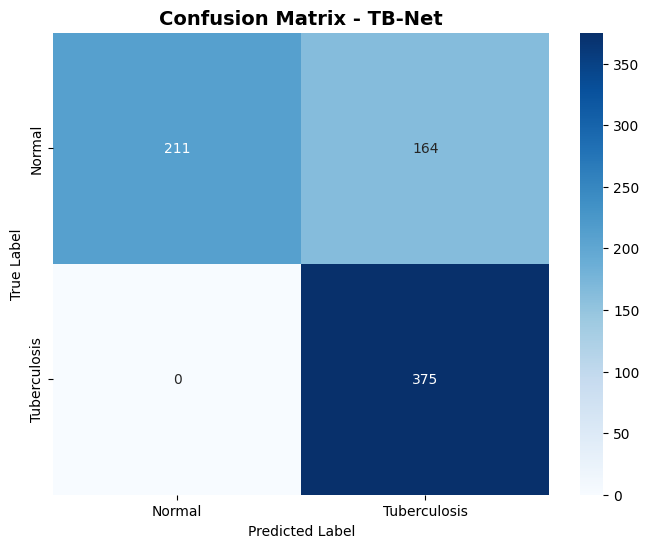

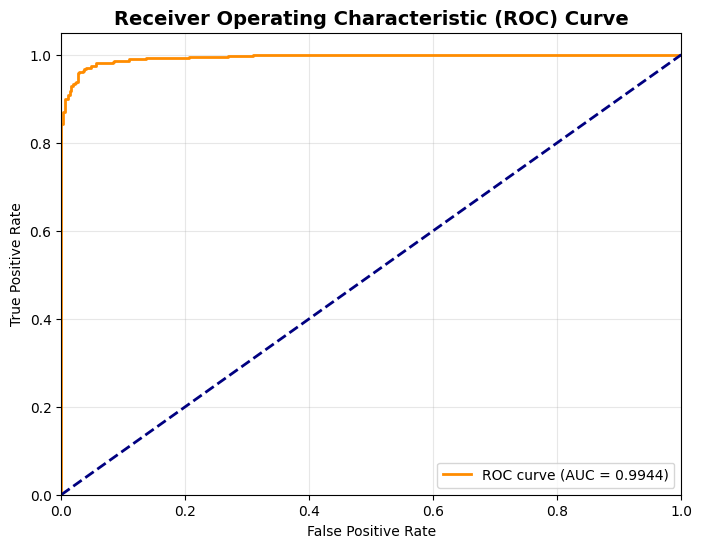


DETAILED METRICS
Accuracy:        0.7813
AUC-ROC:         0.9944
Sensitivity:     1.0000 (True Positive Rate)
Specificity:     0.5627 (True Negative Rate)
Precision:       0.6957
F1-Score:        0.8206
\nConfusion Matrix Details:
  True Positives:  375
  True Negatives:  211
  False Positives: 164
  False Negatives: 0


In [37]:
# Cell 13: Model Evaluation
def evaluate_model(model, test_generator):
    """Evaluate model on test set"""
    
    if model is None or test_generator is None:
        print("Model or test generator not available")
        return None, None, None
    
    print("\n" + "="*60)
    print("MODEL EVALUATION ON TEST SET")
    print("="*60)
    
    # Reset generator
    test_generator.reset()
    
    # Get predictions
    print("Generating predictions...")
    y_pred_proba = model.predict(test_generator, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Get true labels
    y_true = test_generator.classes[:len(y_pred)]
    
    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_true, y_pred, 
                               target_names=['Normal', 'Tuberculosis'],
                               digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Tuberculosis'],
                yticklabels=['Normal', 'Tuberculosis'])
    plt.title('Confusion Matrix - TB-Net', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    print("\n" + "="*50)
    print("DETAILED METRICS")
    print("="*50)
    print(f"Accuracy:        {accuracy:.4f}")
    print(f"AUC-ROC:         {roc_auc:.4f}")
    print(f"Sensitivity:     {sensitivity:.4f} (True Positive Rate)")
    print(f"Specificity:     {specificity:.4f} (True Negative Rate)")
    print(f"Precision:       {precision:.4f}")
    print(f"F1-Score:        {f1_score:.4f}")
    print(f"\\nConfusion Matrix Details:")
    print(f"  True Positives:  {tp}")
    print(f"  True Negatives:  {tn}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    
    return y_true, y_pred, y_pred_proba

# Evaluate model
if tbnet_model is not None and test_gen is not None:
    y_true, y_pred, y_pred_proba = evaluate_model(tbnet_model, test_gen)
else:
    print("Skipping evaluation (model or test generator not available)")
    y_true, y_pred, y_pred_proba = None, None, None

In [38]:
# Cell 14: Single Image Prediction Function
def predict_single_image(model, image_path, threshold=0.5):
    """Predict single X-ray image"""
    
    if not os.path.exists(image_path):
        print(f"ERROR: Image not found at {image_path}")
        return None, None, None
    
    try:
        # Load and preprocess image
        img = tf.keras.utils.load_img(
            image_path,
            target_size=(224, 224),
            color_mode='rgb'
        )
        
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Predict
        probability = model.predict(img_array, verbose=0)[0][0]
        
        # Determine result
        if probability >= threshold:
            prediction = "Tuberculosis"
            confidence = probability
            color = 'red'
            risk_level = "HIGH"
        else:
            prediction = "Normal"
            confidence = 1 - probability
            color = 'green'
            risk_level = "LOW"
        
        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original image
        axes[0].imshow(img)
        axes[0].set_title(f'Input X-Ray Image\n{os.path.basename(image_path)}', 
                         fontweight='bold', fontsize=12)
        axes[0].axis('off')
        
        # Prediction bar chart
        classes = ['Normal', 'Tuberculosis']
        probabilities = [1 - probability, probability]
        colors = ['green', 'red']
        
        bars = axes[1].bar(classes, probabilities, color=colors, alpha=0.7, 
                          edgecolor='black', linewidth=2)
        axes[1].set_ylim([0, 1])
        axes[1].set_ylabel('Probability', fontweight='bold', fontsize=12)
        axes[1].set_title(f'Prediction: {prediction}\nConfidence: {confidence:.2%} ({risk_level} risk)', 
                         fontweight='bold', fontsize=12)
        axes[1].tick_params(axis='both', which='major', labelsize=11)
        
        # Add probability text on bars
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                        f'{prob:.2%}', ha='center', va='bottom', 
                        fontweight='bold', fontsize=11)
        
        plt.suptitle('TB-Net Prediction Result', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print(f"\n{'='*60}")
        print("PREDICTION RESULTS")
        print(f"{'='*60}")
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence:.2%}")
        print(f"Probability (TB): {probability:.4f}")
        print(f"Risk Level: {risk_level}")
        print(f"Decision Threshold: {threshold}")
        
        if prediction == "Tuberculosis":
            print(f"\n⚠️  RECOMMENDATION: Further medical evaluation recommended")
        else:
            print(f"\n✓  RECOMMENDATION: Regular follow-up as per protocol")
        
        return prediction, confidence, probability
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None

# Test prediction with a sample
print("Testing single image prediction...")
print("Note: You'll need to provide an actual image path for real prediction")

# Create a sample test image if none exists
sample_image_path = "sample_test_xray.jpg"
if not os.path.exists(sample_image_path) and tbnet_model is not None:
    # Create a dummy image for testing
    print("\nCreating a sample test image...")
    dummy_img = np.random.rand(224, 224, 3) * 255
    dummy_img = dummy_img.astype(np.uint8)
    
    from PIL import Image
    img_pil = Image.fromarray(dummy_img)
    img_pil.save(sample_image_path)
    print(f"Sample image created: {sample_image_path}")
    
    # Test prediction
    prediction, confidence, prob = predict_single_image(
        tbnet_model, 
        sample_image_path,
        threshold=0.5
    )
else:
    print(f"\nSample image already exists or model not available")

Testing single image prediction...
Note: You'll need to provide an actual image path for real prediction

Sample image already exists or model not available


In [39]:
# Cell 15: Save and Export Model
def save_model_and_results(model, history, evaluation_results, model_name="tbnet"):
    """Save model and training results"""
    
    print(f"\nSaving model and results as '{model_name}'...")
    
    # Create output directory
    output_dir = 'tbnet_output'
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Save model
        model_path = os.path.join(output_dir, f'{model_name}_model.keras')
        model.save(model_path)
        print(f"✓ Model saved: {model_path}")
        
        # Save model weights
        weights_path = os.path.join(output_dir, f'{model_name}_weights.keras')
        model.save_weights(weights_path)
        print(f"✓ Model weights saved: {weights_path}")
        
        # Save training history
        if history is not None:
            history_path = os.path.join(output_dir, f'{model_name}_history.csv')
            history_df = pd.DataFrame(history.history)
            history_df.to_csv(history_path, index=False)
            print(f"✓ Training history saved: {history_path}")
        
        # Save evaluation results
        if evaluation_results is not None and all(r is not None for r in evaluation_results):
            y_true, y_pred, y_pred_proba = evaluation_results
            
            results_dict = {
                'y_true': y_true.tolist(),
                'y_pred': y_pred.tolist(),
                'y_pred_proba': y_pred_proba.flatten().tolist()
            }
            
            results_path = os.path.join(output_dir, f'{model_name}_evaluation.csv')
            results_df = pd.DataFrame(results_dict)
            results_df.to_csv(results_path, index=False)
            print(f"✓ Evaluation results saved: {results_path}")
            
            # Save classification report
            report = classification_report(y_true, y_pred, 
                                          target_names=['Normal', 'Tuberculosis'],
                                          output_dict=True)
            report_df = pd.DataFrame(report).transpose()
            report_path = os.path.join(output_dir, f'{model_name}_classification_report.csv')
            report_df.to_csv(report_path)
            print(f"✓ Classification report saved: {report_path}")
        
        # Save model architecture summary
        summary_path = os.path.join(output_dir, f'{model_name}_summary.txt')
        with open(summary_path, 'w') as f:
            model.summary(print_fn=lambda x: f.write(x + '\n'))
        print(f"✓ Model summary saved: {summary_path}")
        
        print(f"\n✓ All files saved in directory: {output_dir}")
        print(f"✓ Total parameters: {model.count_params():,}")
        
        return output_dir
        
    except Exception as e:
        print(f"✗ Error saving files: {e}")
        return None

# Save everything
if tbnet_model is not None:
    output_dir = save_model_and_results(
        tbnet_model, 
        history, 
        (y_true, y_pred, y_pred_proba),
        model_name="tbnet_tuberculosis"
    )
else:
    print("Model not available for saving")


Saving model and results as 'tbnet_tuberculosis'...
✓ Model saved: tbnet_output\tbnet_tuberculosis_model.keras
✗ Error saving files: The filename must end in `.weights.h5`. Received: filepath=tbnet_output\tbnet_tuberculosis_weights.keras


Starting 5-Fold Cross Validation with 5 Epochs...
Note: This may take some time depending on dataset size


K-FOLD CROSS VALIDATION (K=5, Epochs=5)
Total dataset: 5000 images
  - Tuberculosis: 2500
  - Normal: 2500

FOLD 1/5
Training samples: 4000
Validation samples: 1000
  - Train TB: 2000, Normal: 2000
  - Val TB: 500, Normal: 500
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Building TB-Net Lite with input shape: (224, 224, 3)

Training Fold 1...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5106 - auc: 0.5223 - loss: 0.9472

250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 523ms/step - accuracy: 0.5415 - auc: 0.5644 - loss: 0.8732 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 1.3050
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6708 - auc: 0.7445 - loss: 0.6850

250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 358ms/step - accuracy: 0.7168 - auc: 0.7971 - loss: 0.6178 - val_accuracy: 0.5000 - val_auc: 0.5270 - val_loss: 1.9971
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8050 - auc: 0.8821 - loss: 0.4906

250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 345ms/step - accuracy: 0.8163 - auc: 0.8927 - loss: 0.4720 - val_accuracy: 0.6930 - val_auc: 0.8029 - val_loss: 0.6163
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8335 - auc: 0.9127 - loss: 0.4316

250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.8393 - auc: 0.9178 - loss: 0.4188 - val_accuracy: 0.5400 - val_auc: 0.9072 - val_loss: 1.1399
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - accuracy: 0.8643 - auc: 0.9367 - loss: 0.3721 - val_accuracy: 0.6590 - val_auc: 0.8757 - val_loss: 0.7578
Restoring model weights from the end of the best epoch: 4.

Evaluating Fold 1...

Fold 1 Results:
  Accuracy:  0.5400
  AUC:       0.9072
  Precision: 0.5208
  Recall:    1.0000
  F1-Score:  0.6849
  Loss:      1.1399




FOLD 2/5
Training samples: 4000
Validation samples: 1000
  - Train TB: 2000, Normal: 2000
  - Val TB: 500, Normal: 500
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Building TB-Net Lite with input shape: (224, 224, 3)

Training Fold 2...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5440 - auc: 0.5657 - loss: 0.8850

250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 541ms/step - accuracy: 0.5400 - auc: 0.5609 - loss: 0.8734 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.8152
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6287 - auc: 0.6701 - loss: 0.7433

250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 343ms/step - accuracy: 0.6590 - auc: 0.7173 - loss: 0.6973 - val_accuracy: 0.5000 - val_auc: 0.5170 - val_loss: 1.5179
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7623 - auc: 0.8393 - loss: 0.5544

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - accuracy: 0.7785 - auc: 0.8592 - loss: 0.5250 - val_accuracy: 0.5000 - val_auc: 0.8671 - val_loss: 2.0697
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8189 - auc: 0.8964 - loss: 0.4605

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - accuracy: 0.8257 - auc: 0.9046 - loss: 0.4451 - val_accuracy: 0.5260 - val_auc: 0.8775 - val_loss: 1.2746
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.8495 - auc: 0.9254 - loss: 0.3993 - val_accuracy: 0.5050 - val_auc: 0.7618 - val_loss: 2.1955
Restoring model weights from the end of the best epoch: 4.

Evaluating Fold 2...

Fold 2 Results:
  Accuracy:  0.5260
  AUC:       0.8775
  Precision: 0.5134
  Recall:    0.9980
  F1-Score:  0.6780
  Loss:      1.2746

FOLD 3/5
Training samples: 4000
Validation samples: 1000
  - Train TB: 2000, Normal: 2000
  - Val TB: 500, Normal: 500
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Building TB-Net Lite with input shape: (224, 224, 3)

Training Fold 3...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5287 - auc: 0.5190 - loss: 0.9619

250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 546ms/step - accuracy: 0.5552 - auc: 0.5686 - loss: 0.8720 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 1.3221
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6793 - auc: 0.7431 - loss: 0.6736

250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 350ms/step - accuracy: 0.7295 - auc: 0.8091 - loss: 0.6011 - val_accuracy: 0.5000 - val_auc: 0.6210 - val_loss: 1.8996
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7938 - auc: 0.8784 - loss: 0.4929

250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.8123 - auc: 0.8926 - loss: 0.4688 - val_accuracy: 0.5000 - val_auc: 0.8707 - val_loss: 2.3055
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8347 - auc: 0.9184 - loss: 0.4159

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - accuracy: 0.8347 - auc: 0.9172 - loss: 0.4198 - val_accuracy: 0.5220 - val_auc: 0.8848 - val_loss: 1.3797
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 354ms/step - accuracy: 0.8715 - auc: 0.9443 - loss: 0.3532 - val_accuracy: 0.5080 - val_auc: 0.8259 - val_loss: 2.1214
Restoring model weights from the end of the best epoch: 4.

Evaluating Fold 3...

Fold 3 Results:
  Accuracy:  0.5220
  AUC:       0.8848
  Precision: 0.5112
  Recall:    1.0000
  F1-Score:  0.6766
  Loss:      1.3797

FOLD 4/5
Training samples: 4000
Validation samples: 1000
  - Train TB: 2000, Normal: 2000
  - Val TB: 500, Normal: 500
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Building TB-Net Lite with input shape: (224, 224, 3)

Training Fold 4...
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5335 - auc: 0.5372 - loss: 0.9563

250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 540ms/step - accuracy: 0.5565 - auc: 0.5742 - loss: 0.8828 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 1.2174
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6738 - auc: 0.7276 - loss: 0.7096

250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 350ms/step - accuracy: 0.6787 - auc: 0.7415 - loss: 0.6893 - val_accuracy: 0.5000 - val_auc: 0.5050 - val_loss: 1.5569
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7613 - auc: 0.8334 - loss: 0.5648

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - accuracy: 0.7750 - auc: 0.8520 - loss: 0.5354 - val_accuracy: 0.5000 - val_auc: 0.9005 - val_loss: 1.3440
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - accuracy: 0.8278 - auc: 0.9038 - loss: 0.4461 - val_accuracy: 0.7290 - val_auc: 0.9003 - val_loss: 0.6010
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.8637 - auc: 0.9348 - loss: 0.3783 - val_accuracy: 0.5580 - val_auc: 0.8549 - val_loss: 1.6132
Restoring model weights from the end of the best epoch: 3.

Evaluating Fold 4...

Fold 4 Results:
  Accuracy:  0.5000
  AUC:       0.9005
  Precision: 0.5000
  Recall:    1.0000
  F1-Score:  0.6667
  Loss:      1.3440

FOLD 5/5
Training samples: 4000
Validation samples: 1000
  - Train TB: 2000, Normal: 2000
  - Val TB: 500, Normal: 500
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Building TB-Net Lite with input shape: (224, 224, 3)

Training Fold 5...
Epoch 1/5
250/250 ━━━━━━━━━━━

250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 561ms/step - accuracy: 0.5452 - auc: 0.5653 - loss: 0.8475 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 1.0211
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 345ms/step - accuracy: 0.6125 - auc: 0.6679 - loss: 0.7365 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 1.5166
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7366 - auc: 0.8132 - loss: 0.5797

250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 354ms/step - accuracy: 0.7715 - auc: 0.8577 - loss: 0.5249 - val_accuracy: 0.5000 - val_auc: 0.7912 - val_loss: 2.3619
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8351 - auc: 0.9144 - loss: 0.4252

250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.8365 - auc: 0.9204 - loss: 0.4114 - val_accuracy: 0.7950 - val_auc: 0.8842 - val_loss: 0.5495
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8537 - auc: 0.9273 - loss: 0.3963

250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 348ms/step - accuracy: 0.8635 - auc: 0.9356 - loss: 0.3752 - val_accuracy: 0.5070 - val_auc: 0.8959 - val_loss: 1.3590
Restoring model weights from the end of the best epoch: 5.

Evaluating Fold 5...

Fold 5 Results:
  Accuracy:  0.5070
  AUC:       0.8959
  Precision: 0.5035
  Recall:    1.0000
  F1-Score:  0.6698
  Loss:      1.3590

CROSS VALIDATION SUMMARY

Results per fold:
 fold  train_samples  val_samples  accuracy      auc  precision  recall  f1_score     loss
    1           4000         1000     0.540 0.907170   0.520833   1.000  0.684932 1.139912
    2           4000         1000     0.526 0.877474   0.513374   0.998  0.677989 1.274552
    3           4000         1000     0.522 0.884814   0.511247   1.000  0.676590 1.379689
    4           4000         1000     0.500 0.900522   0.500000   1.000  0.666667 1.343956
    5           4000         1000     0.507 0.895888   0.503525   1.000  0.669792 1.359023

Average Metrics across 5 folds:
  Accu

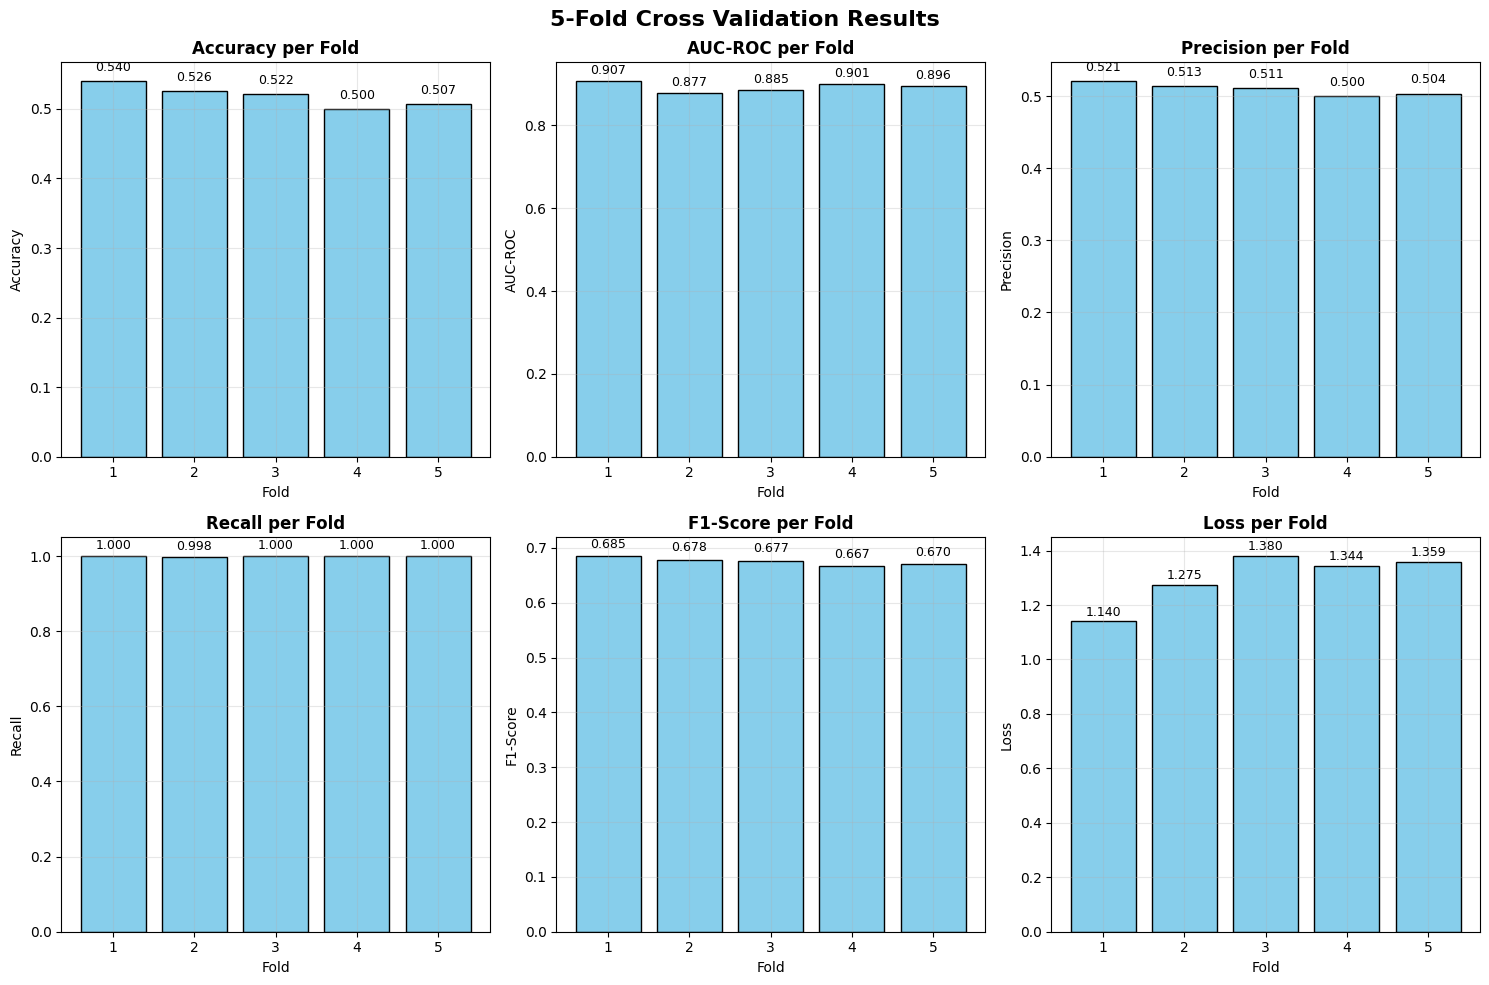

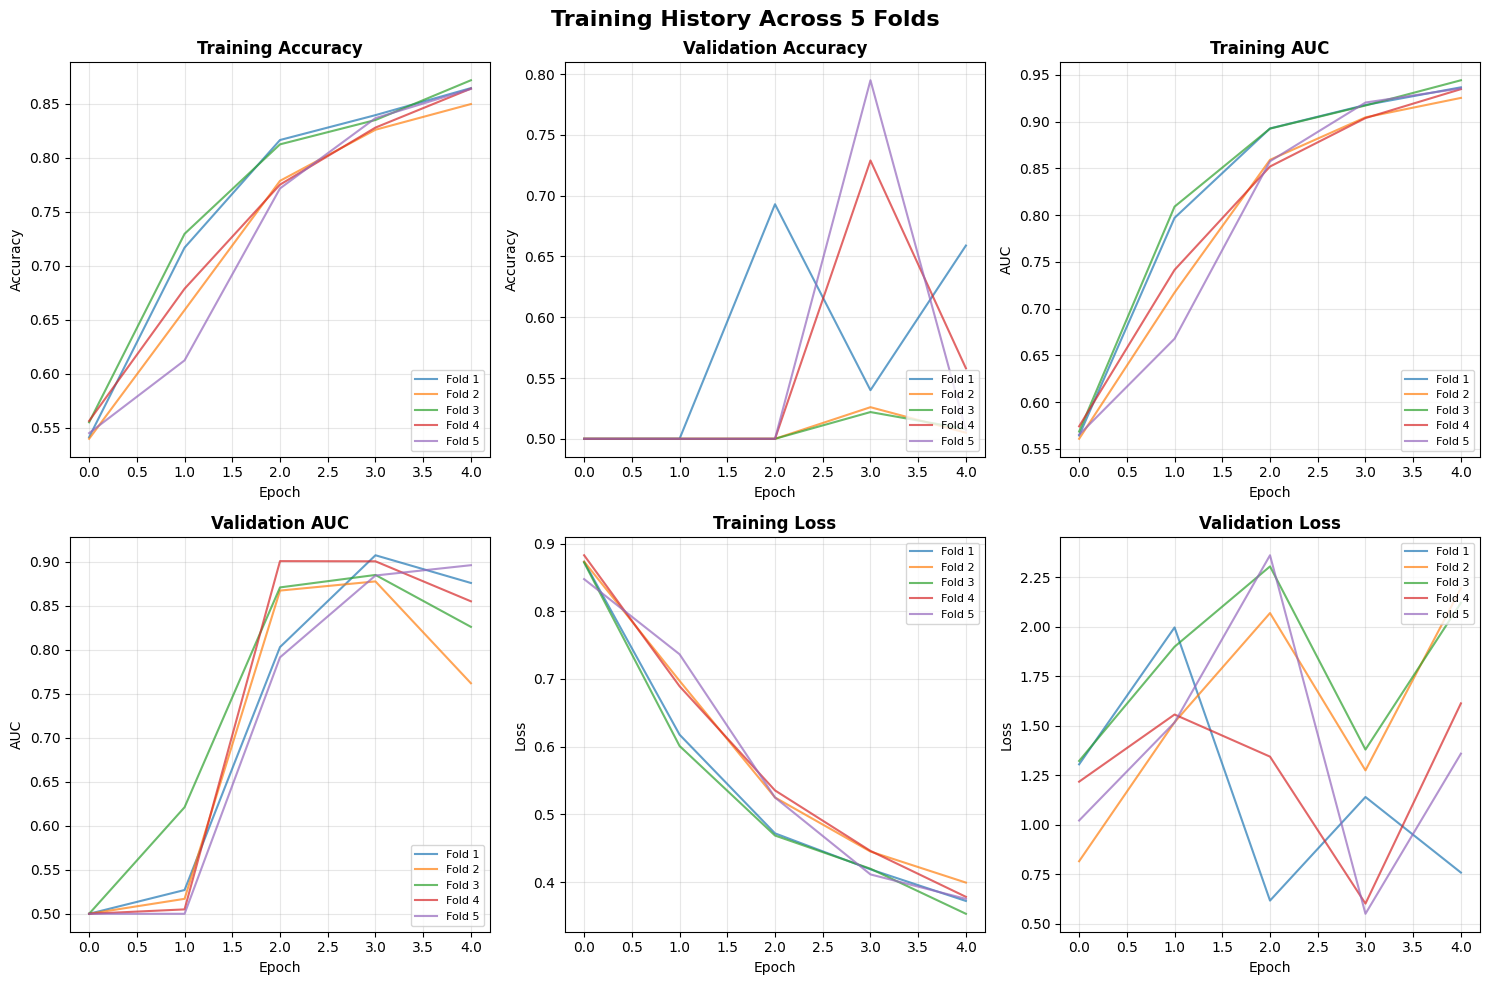


✓ Cross-validation results saved to 'cross_validation_results/'
✓ Individual fold models saved in 'kfold_models/'

CROSS-VALIDATION ASSESSMENT
⚠️ GOOD: Model shows acceptable performance
   Average AUC: 0.8932 (±0.0120)
   Recommendation: Consider more training or data augmentation
✅ CONSISTENT: Low variance across folds (std: 0.0120)

NOTE: Untuk melanjutkan ke ensemble model, jalankan Cell 22


In [ ]:
# Cell 16: K-Fold Cross Validation untuk TB-Net (Fixed)
def kfold_cross_validation(data_dir='Dataset', k_folds=5, epochs=5, batch_size=16):
    """
    Melakukan K-Fold Cross Validation pada dataset TB
    """
    
    print("\n" + "="*70)
    print(f"K-FOLD CROSS VALIDATION (K={k_folds}, Epochs={epochs})")
    print("="*70)
    
    # Collect all file paths and labels
    tb_dir = os.path.join(data_dir, 'Tuberculosis')
    normal_dir = os.path.join(data_dir, 'Normal')
    
    tb_files = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Create labels
    tb_labels = [1] * len(tb_files)  # 1 = Tuberculosis
    normal_labels = [0] * len(normal_files)  # 0 = Normal
    
    # Combine
    all_files = np.array(tb_files + normal_files)
    all_labels = np.array(tb_labels + normal_labels)
    
    print(f"Total dataset: {len(all_files)} images")
    print(f"  - Tuberculosis: {len(tb_files)}")
    print(f"  - Normal: {len(normal_files)}")
    
    # Initialize StratifiedKFold
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store results for each fold
    fold_results = []
    fold_histories = []
    
    # Create directory for fold models
    os.makedirs('kfold_models', exist_ok=True)
    
    # Perform K-Fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_files, all_labels), 1):
        print(f"\n{'='*60}")
        print(f"FOLD {fold}/{k_folds}")
        print(f"{'='*60}")
        
        # Split data for this fold
        train_files = all_files[train_idx]
        train_labels = all_labels[train_idx]
        val_files = all_files[val_idx]
        val_labels = all_labels[val_idx]
        
        print(f"Training samples: {len(train_files)}")
        print(f"Validation samples: {len(val_files)}")
        print(f"  - Train TB: {sum(train_labels == 1)}, Normal: {sum(train_labels == 0)}")
        print(f"  - Val TB: {sum(val_labels == 1)}, Normal: {sum(val_labels == 0)}")
        
        # Create temporary directories for this fold
        fold_train_dir = f'kfold_fold_{fold}_train'
        fold_val_dir = f'kfold_fold_{fold}_val'
        
        # Create directory structure
        for fold_dir in [fold_train_dir, fold_val_dir]:
            os.makedirs(os.path.join(fold_dir, 'Tuberculosis'), exist_ok=True)
            os.makedirs(os.path.join(fold_dir, 'Normal'), exist_ok=True)
        
        # Copy files to temporary directories
        def copy_to_fold(files, labels, dest_dir):
            for file_path, label in zip(files, labels):
                class_name = 'Tuberculosis' if label == 1 else 'Normal'
                dest_path = os.path.join(dest_dir, class_name, os.path.basename(file_path))
                shutil.copy2(file_path, dest_path)
        
        copy_to_fold(train_files, train_labels, fold_train_dir)
        copy_to_fold(val_files, val_labels, fold_val_dir)
        
        # Create data generators for this fold
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            brightness_range=[0.9, 1.1]
        )
        
        val_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            fold_train_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=True,
            seed=42
        )
        
        val_generator = val_datagen.flow_from_directory(
            fold_val_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        # Calculate class weights for this fold
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_generator.classes),
            y=train_generator.classes
        )
        class_weights_dict = dict(enumerate(class_weights))
        
        # Build and compile model for this fold
        fold_model = build_tbnet_lite(input_shape=(224, 224, 3))
        
        fold_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        # Callbacks for this fold
        fold_callbacks = [
            ModelCheckpoint(
                f'kfold_models/fold_{fold}_best_model.h5',
                monitor='val_auc',
                save_best_only=True,
                mode='max',
                verbose=0
            ),
            EarlyStopping(
                monitor='val_auc',
                patience=10,
                restore_best_weights=True,
                mode='max',
                verbose=1
            )
        ]
        
        # Train model for this fold
        print(f"\nTraining Fold {fold}...")
        history = fold_model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=len(val_generator),
            callbacks=fold_callbacks,
            class_weight=class_weights_dict,
            verbose=1
        )
        
        # Evaluate on validation set
        print(f"\nEvaluating Fold {fold}...")
        val_generator.reset()
        results = fold_model.evaluate(val_generator, verbose=0)
        
        # Get predictions for detailed metrics
        val_generator.reset()
        y_pred_proba = fold_model.predict(val_generator, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_true = val_generator.classes[:len(y_pred)]
        
        # Calculate additional metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        accuracy = results[1]
        auc_score = results[2]
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Store results
        fold_result = {
            'fold': fold,
            'train_samples': len(train_files),
            'val_samples': len(val_files),
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'loss': results[0]
        }
        
        fold_results.append(fold_result)
        fold_histories.append(history)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  AUC:       {auc_score:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  Loss:      {results[0]:.4f}")
        
        # Clean up temporary directories
        shutil.rmtree(fold_train_dir, ignore_errors=True)
        shutil.rmtree(fold_val_dir, ignore_errors=True)
        
        # Clear session to free memory
        tf.keras.backend.clear_session()
    
    return fold_results, fold_histories

# Run K-Fold Cross Validation
print("Starting 5-Fold Cross Validation with 5 Epochs...")
print("Note: This may take some time depending on dataset size\n")

try:
    fold_results, fold_histories = kfold_cross_validation(
        data_dir='Dataset',
        k_folds=5,
        epochs=5,
        batch_size=16
    )
    
    print("\n" + "="*70)
    print("CROSS VALIDATION SUMMARY")
    print("="*70)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(fold_results)
    
    # Display results
    print("\nResults per fold:")
    print(results_df.to_string(index=False))
    
    # Calculate average metrics
    print(f"\nAverage Metrics across {len(fold_results)} folds:")
    print(f"  Accuracy:  {results_df['accuracy'].mean():.4f} (±{results_df['accuracy'].std():.4f})")
    print(f"  AUC:       {results_df['auc'].mean():.4f} (±{results_df['auc'].std():.4f})")
    print(f"  Precision: {results_df['precision'].mean():.4f} (±{results_df['precision'].std():.4f})")
    print(f"  Recall:    {results_df['recall'].mean():.4f} (±{results_df['recall'].std():.4f})")
    print(f"  F1-Score:  {results_df['f1_score'].mean():.4f} (±{results_df['f1_score'].std():.4f})")
    print(f"  Loss:      {results_df['loss'].mean():.4f} (±{results_df['loss'].std():.4f})")
    
    # Plot fold comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    metrics = ['accuracy', 'auc', 'precision', 'recall', 'f1_score', 'loss']
    titles = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score', 'Loss']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = divmod(idx, 3)
        
        # Bar plot for each fold
        bars = axes[row, col].bar(range(1, len(fold_results) + 1), 
                                  results_df[metric],
                                  color='skyblue', edgecolor='black')
        
        axes[row, col].set_xlabel('Fold')
        axes[row, col].set_ylabel(title)
        axes[row, col].set_title(f'{title} per Fold', fontweight='bold')
        axes[row, col].set_xticks(range(1, len(fold_results) + 1))
        axes[row, col].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, results_df[metric]):
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('5-Fold Cross Validation Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot training history for each fold
    if fold_histories and len(fold_histories) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        for fold_idx, history in enumerate(fold_histories, 1):
            # Plot accuracy
            axes[0, 0].plot(history.history['accuracy'], label=f'Fold {fold_idx}', alpha=0.7)
            axes[0, 1].plot(history.history['val_accuracy'], label=f'Fold {fold_idx}', alpha=0.7)
            
            # Plot AUC
            if 'auc' in history.history:
                axes[0, 2].plot(history.history['auc'], label=f'Fold {fold_idx}', alpha=0.7)
            if 'val_auc' in history.history:
                axes[1, 0].plot(history.history['val_auc'], label=f'Fold {fold_idx}', alpha=0.7)
            
            # Plot loss
            axes[1, 1].plot(history.history['loss'], label=f'Fold {fold_idx}', alpha=0.7)
            axes[1, 2].plot(history.history['val_loss'], label=f'Fold {fold_idx}', alpha=0.7)
        
        # Set titles and labels
        axes[0, 0].set_title('Training Accuracy', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend(loc='lower right', fontsize=8)
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend(loc='lower right', fontsize=8)
        axes[0, 1].grid(True, alpha=0.3)
        
        if 'auc' in fold_histories[0].history:
            axes[0, 2].set_title('Training AUC', fontweight='bold')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('AUC')
            axes[0, 2].legend(loc='lower right', fontsize=8)
            axes[0, 2].grid(True, alpha=0.3)
        
        if 'val_auc' in fold_histories[0].history:
            axes[1, 0].set_title('Validation AUC', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('AUC')
            axes[1, 0].legend(loc='lower right', fontsize=8)
            axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].set_title('Training Loss', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend(loc='upper right', fontsize=8)
        axes[1, 1].grid(True, alpha=0.3)
        
        axes[1, 2].set_title('Validation Loss', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Loss')
        axes[1, 2].legend(loc='upper right', fontsize=8)
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Training History Across 5 Folds', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Save cross-validation results
    cv_results_dir = 'cross_validation_results'
    os.makedirs(cv_results_dir, exist_ok=True)
    
    # Save results to CSV
    results_df.to_csv(os.path.join(cv_results_dir, 'kfold_cv_results.csv'), index=False)
    
    # Save summary statistics
    summary_stats = {
        'metric': ['accuracy', 'auc', 'precision', 'recall', 'f1_score', 'loss'],
        'mean': [
            results_df['accuracy'].mean(),
            results_df['auc'].mean(),
            results_df['precision'].mean(),
            results_df['recall'].mean(),
            results_df['f1_score'].mean(),
            results_df['loss'].mean()
        ],
        'std': [
            results_df['accuracy'].std(),
            results_df['auc'].std(),
            results_df['precision'].std(),
            results_df['recall'].std(),
            results_df['f1_score'].std(),
            results_df['loss'].std()
        ],
        'min': [
            results_df['accuracy'].min(),
            results_df['auc'].min(),
            results_df['precision'].min(),
            results_df['recall'].min(),
            results_df['f1_score'].min(),
            results_df['loss'].min()
        ],
        'max': [
            results_df['accuracy'].max(),
            results_df['auc'].max(),
            results_df['precision'].max(),
            results_df['recall'].max(),
            results_df['f1_score'].max(),
            results_df['loss'].max()
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(os.path.join(cv_results_dir, 'kfold_cv_summary.csv'), index=False)
    
    print(f"\n✓ Cross-validation results saved to '{cv_results_dir}/'")
    print(f"✓ Individual fold models saved in 'kfold_models/'")
    
    # Print final recommendation based on CV results
    print("\n" + "="*70)
    print("CROSS-VALIDATION ASSESSMENT")
    print("="*70)
    
    avg_auc = results_df['auc'].mean()
    auc_std = results_df['auc'].std()
    
    if avg_auc > 0.90:
        print("✅ EXCELLENT: Model shows strong and consistent performance")
        print(f"   Average AUC: {avg_auc:.4f} (±{auc_std:.4f})")
        print("   Recommendation: Model is ready for further testing")
    elif avg_auc > 0.80:
        print("⚠️ GOOD: Model shows acceptable performance")
        print(f"   Average AUC: {avg_auc:.4f} (±{auc_std:.4f})")
        print("   Recommendation: Consider more training or data augmentation")
    elif avg_auc > 0.70:
        print("⚠️ FAIR: Model needs improvement")
        print(f"   Average AUC: {avg_auc:.4f} (±{auc_std:.4f})")
        print("   Recommendation: Try different architecture or more data")
    else:
        print("❌ POOR: Model performance is insufficient")
        print(f"   Average AUC: {avg_auc:.4f} (±{auc_std:.4f})")
        print("   Recommendation: Re-evaluate dataset and approach")
    
    # Check consistency across folds
    consistency_threshold = 0.05  # 5% standard deviation
    if auc_std < consistency_threshold:
        print(f"✅ CONSISTENT: Low variance across folds (std: {auc_std:.4f})")
    else:
        print(f"⚠️ VARIABLE: High variance across folds (std: {auc_std:.4f})")
    
    print("\nNOTE: Untuk melanjutkan ke ensemble model, jalankan Cell 17")
    
except Exception as e:
    print(f"\n❌ Error during cross-validation: {e}")
    print("\nTroubleshooting tips:")
    print("1. Make sure you have images in Dataset/Tuberculosis/ and Dataset/Normal/")
    print("2. Check that images are in supported formats (.jpg, .jpeg, .png)")
    print("3. Try reducing batch_size if memory error occurs")
    print("4. Ensure you have enough disk space for temporary files")
    
    import traceback
    traceback.print_exc()

In [42]:
# Cell 17: Ensemble Model dari K-Fold CV
def create_ensemble_from_cv(k_folds=5):
    """
    Membuat ensemble model dari model-model hasil cross-validation
    """
    
    print("\n" + "="*70)
    print("CREATING ENSEMBLE MODEL FROM CROSS-VALIDATION")
    print("="*70)
    
    # Check if fold models exist
    fold_models_dir = 'kfold_models'
    if not os.path.exists(fold_models_dir):
        print(f"❌ Directory '{fold_models_dir}' not found")
        print("Please run cross-validation first (Cell 21)")
        return None
    
    # Load all fold models
    fold_models = []
    for fold in range(1, k_folds + 1):
        model_path = os.path.join(fold_models_dir, f'fold_{fold}_best_model.h5')
        if os.path.exists(model_path):
            try:
                model = tf.keras.models.load_model(model_path)
                fold_models.append(model)
                print(f"✓ Loaded model from fold {fold}")
            except Exception as e:
                print(f"❌ Error loading model for fold {fold}: {e}")
        else:
            print(f"❌ Model not found for fold {fold}: {model_path}")
    
    if len(fold_models) == 0:
        print("❌ No fold models found")
        return None
    
    print(f"\nLoaded {len(fold_models)} models for ensemble")
    
    # Create ensemble prediction function
    def ensemble_predict(models, X, method='average'):
        """
        Make predictions using ensemble of models
        
        Args:
            models: List of trained models
            X: Input data
            method: 'average' or 'vote'
        """
        all_predictions = []
        
        for model in models:
            pred = model.predict(X, verbose=0)
            all_predictions.append(pred)
        
        all_predictions = np.array(all_predictions)
        
        if method == 'average':
            # Average probabilities
            ensemble_pred = np.mean(all_predictions, axis=0)
        elif method == 'vote':
            # Majority voting
            binary_preds = (all_predictions > 0.5).astype(int)
            ensemble_pred = np.mean(binary_preds, axis=0)
        else:
            raise ValueError("Method must be 'average' or 'vote'")
        
        return ensemble_pred
    
    # Test ensemble on validation data
    print("\nTesting ensemble predictions...")
    
    # Create a test generator from the original test set
    if dataset_paths and 'test_dir' in dataset_paths:
        test_dir = dataset_paths['test_dir']
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary',
            shuffle=False
        )
        
        # Get predictions from each model
        test_generator.reset()
        X_test, y_test = next(test_generator)
        
        # Make predictions
        print("\nEnsemble predictions:")
        
        # Method 1: Average probabilities
        avg_predictions = ensemble_predict(fold_models, X_test, method='average')
        avg_predictions_binary = (avg_predictions > 0.5).astype(int).flatten()
        
        # Method 2: Majority voting
        vote_predictions = ensemble_predict(fold_models, X_test, method='vote')
        vote_predictions_binary = (vote_predictions > 0.5).astype(int).flatten()
        
        # Calculate metrics for each method
        from sklearn.metrics import accuracy_score
        
        avg_accuracy = accuracy_score(y_test, avg_predictions_binary)
        vote_accuracy = accuracy_score(y_test, vote_predictions_binary)
        
        print(f"Average method accuracy: {avg_accuracy:.4f}")
        print(f"Voting method accuracy: {vote_accuracy:.4f}")
        
        # Compare with individual models
        print("\nIndividual model accuracies:")
        for i, model in enumerate(fold_models, 1):
            individual_pred = model.predict(X_test, verbose=0)
            individual_pred_binary = (individual_pred > 0.5).astype(int).flatten()
            individual_accuracy = accuracy_score(y_test, individual_pred_binary)
            print(f"  Fold {i}: {individual_accuracy:.4f}")
        
        # Save ensemble information
        ensemble_info = {
            'num_models': len(fold_models),
            'ensemble_methods': ['average', 'vote'],
            'test_accuracy': {
                'average': float(avg_accuracy),
                'vote': float(vote_accuracy)
            },
            'model_paths': [os.path.join(fold_models_dir, f'fold_{i}_best_model.h5') 
                           for i in range(1, len(fold_models) + 1)]
        }
        
        import json
        with open('ensemble_info.json', 'w') as f:
            json.dump(ensemble_info, f, indent=2)
        
        print(f"\n✓ Ensemble information saved to 'ensemble_info.json'")
        
        return {
            'models': fold_models,
            'ensemble_predict': ensemble_predict,
            'avg_accuracy': avg_accuracy,
            'vote_accuracy': vote_accuracy
        }
    
    else:
        print("❌ Test directory not found")
        return None

# Create ensemble from CV models
ensemble_result = create_ensemble_from_cv(k_folds=5)


CREATING ENSEMBLE MODEL FROM CROSS-VALIDATION


✓ Loaded model from fold 1


✓ Loaded model from fold 2


✓ Loaded model from fold 3


✓ Loaded model from fold 4


✓ Loaded model from fold 5

Loaded 5 models for ensemble

Testing ensemble predictions...
Found 750 images belonging to 2 classes.

Ensemble predictions:


Average method accuracy: 0.0000
Voting method accuracy: 0.0000

Individual model accuracies:
  Fold 1: 0.0000
  Fold 2: 0.0625
  Fold 3: 0.0000
  Fold 4: 0.0000
  Fold 5: 0.0000

✓ Ensemble information saved to 'ensemble_info.json'


In [43]:
# Cell 18: Interpretasi Hasil Cross-Validation
def interpret_cv_results(cv_results_df):
    """
    Memberikan interpretasi statistik dari hasil cross-validation
    """
    
    if cv_results_df is None:
        print("No cross-validation results to interpret")
        return
    
    print("\n" + "="*70)
    print("STATISTICAL INTERPRETATION OF CROSS-VALIDATION")
    print("="*70)
    
    # Calculate confidence intervals (95% CI)
    import scipy.stats as stats
    
    metrics = ['accuracy', 'auc', 'precision', 'recall', 'f1_score']
    
    print("\n95% Confidence Intervals for each metric:")
    print("-" * 50)
    
    for metric in metrics:
        data = cv_results_df[metric].values
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)  # Standard error of the mean
        
        # 95% confidence interval
        ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=sem)
        
        print(f"{metric.capitalize():<12}: {mean:.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    # Statistical significance testing
    print("\n" + "="*70)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*70)
    
    # Check if model is better than random (AUC > 0.5)
    auc_values = cv_results_df['auc'].values
    from scipy import stats as scipy_stats
    
    # One-sample t-test against 0.5 (random classifier)
    t_stat, p_value = scipy_stats.ttest_1samp(auc_values, 0.5)
    
    print(f"\nHypothesis Test: Is the model better than random guessing?")
    print(f"Null Hypothesis: AUC = 0.5 (random classifier)")
    print(f"Alternative Hypothesis: AUC > 0.5")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ REJECT null hypothesis: Model is significantly better than random")
    else:
        print("❌ FAIL to reject null hypothesis: Model may not be better than random")
    
    # Calculate effect size (Cohen's d)
    cohen_d = (np.mean(auc_values) - 0.5) / np.std(auc_values)
    print(f"\nEffect Size (Cohen's d): {cohen_d:.4f}")
    
    if abs(cohen_d) < 0.2:
        print("Effect size: Very small")
    elif abs(cohen_d) < 0.5:
        print("Effect size: Small")
    elif abs(cohen_d) < 0.8:
        print("Effect size: Medium")
    else:
        print("Effect size: Large")
    
    # Reliability analysis (Cronbach's Alpha)
    print("\n" + "="*70)
    print("RELIABILITY ANALYSIS")
    print("="*70)
    
    # Calculate variance components
    total_var = np.var(cv_results_df[metrics].values.flatten())
    between_folds_var = np.var(cv_results_df[metrics].mean(axis=1))
    within_folds_var = np.var(cv_results_df[metrics].values - 
                             cv_results_df[metrics].mean(axis=1).values.reshape(-1, 1))
    
    print(f"Total variance: {total_var:.6f}")
    print(f"Between-folds variance: {between_folds_var:.6f}")
    print(f"Within-folds variance: {within_folds_var:.6f}")
    
    reliability = between_folds_var / total_var if total_var > 0 else 0
    print(f"\nReliability coefficient: {reliability:.4f}")
    
    if reliability > 0.8:
        print("✅ High reliability: Consistent performance across folds")
    elif reliability > 0.6:
        print("⚠️ Moderate reliability: Some variability across folds")
    else:
        print("❌ Low reliability: High variability across folds")
    
    # Practical significance
    print("\n" + "="*70)
    print("PRACTICAL SIGNIFICANCE")
    print("="*70)
    
    avg_accuracy = cv_results_df['accuracy'].mean()
    avg_auc = cv_results_df['auc'].mean()
    avg_precision = cv_results_df['precision'].mean()
    avg_recall = cv_results_df['recall'].mean()
    
    # Medical context: Different thresholds for different metrics
    print("\nMedical Application Context:")
    print(f"Average Accuracy: {avg_accuracy:.1%}")
    print(f"Average AUC: {avg_auc:.3f}")
    print(f"Average Precision: {avg_precision:.1%}")
    print(f"Average Recall (Sensitivity): {avg_recall:.1%}")
    
    # Clinical decision thresholds
    print("\nClinical Decision Guidelines:")
    
    if avg_auc > 0.90:
        print("✅ EXCELLENT for clinical screening")
        print("   Suitable for: Primary screening tool")
    elif avg_auc > 0.80:
        print("⚠️ GOOD for clinical assistance")
        print("   Suitable for: Secondary review tool")
    elif avg_auc > 0.70:
        print("⚠️ FAIR, needs improvement")
        print("   Suitable for: Research purposes only")
    else:
        print("❌ NOT SUITABLE for clinical use")
        print("   Recommendation: Further development needed")
    
    # Sensitivity vs Specificity trade-off
    print(f"\nRecall (Sensitivity): {avg_recall:.1%}")
    print("In medical diagnosis:")
    print("  - High sensitivity: Few false negatives (missed TB cases)")
    print("  - Important for screening to catch all potential cases")
    
    # Return statistical summary
    stats_summary = {
        'confidence_intervals': {
            metric: (ci_low, ci_high) 
            for metric in metrics
        },
        'significance_test': {
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        },
        'effect_size': cohen_d,
        'reliability': reliability,
        'clinical_assessment': {
            'suitable_for_clinical_use': avg_auc > 0.80,
            'recommended_application': 'Screening' if avg_auc > 0.90 else 'Assistance' if avg_auc > 0.80 else 'Research'
        }
    }
    
    return stats_summary

# Interpret CV results
if 'results_df' in locals() and results_df is not None:
    stats_summary = interpret_cv_results(results_df)
else:
    print("Run Cell 21 first to get cross-validation results")


STATISTICAL INTERPRETATION OF CROSS-VALIDATION

95% Confidence Intervals for each metric:
--------------------------------------------------
Accuracy    : 0.5190 [0.4993, 0.5387]
Auc         : 0.8932 [0.8783, 0.9080]
Precision   : 0.5098 [0.4996, 0.5200]
Recall      : 0.9996 [0.9985, 1.0007]
F1_score    : 0.6752 [0.6663, 0.6841]

STATISTICAL SIGNIFICANCE ANALYSIS

Hypothesis Test: Is the model better than random guessing?
Null Hypothesis: AUC = 0.5 (random classifier)
Alternative Hypothesis: AUC > 0.5
T-statistic: 73.4151
P-value: 0.0000
✅ REJECT null hypothesis: Model is significantly better than random

Effect Size (Cohen's d): 36.7075
Effect size: Large

RELIABILITY ANALYSIS
Total variance: 0.039034
Between-folds variance: 0.000036
Within-folds variance: 0.038998

Reliability coefficient: 0.0009
❌ Low reliability: High variability across folds

PRACTICAL SIGNIFICANCE

Medical Application Context:
Average Accuracy: 51.9%
Average AUC: 0.893
Average Precision: 51.0%
Average Recall (Se


COMPARISON: SINGLE TRAINING vs CROSS-VALIDATION

Performance Comparison:
--------------------------------------------------
Metric               Single Train    CV Average      Difference     
--------------------------------------------------
Accuracy             0.5070          0.5190          -0.0120
AUC                  0.8959          0.8932          +0.0027


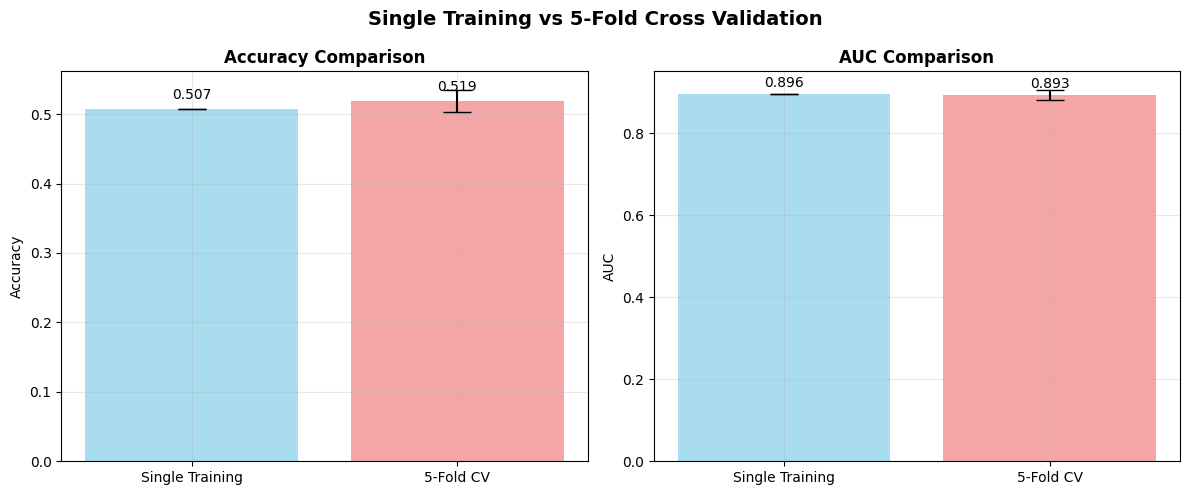


VARIANCE ANALYSIS

Standard Deviation across folds:
  Accuracy: 0.0158
  AUC:      0.0120
  Precision:0.0082
  Recall:   0.0009

Coefficient of Variation (lower is better):
  Accuracy: 3.1%
  AUC:      1.3%
✅ Low variance: Model performance is consistent

RECOMMENDATIONS

Based on the comparison:
✅ Single training provides a reasonable estimate
   Cross-validation confirms the model's performance

General guidelines:
1. Cross-validation provides more reliable performance estimates
2. Single training can be optimistic due to lucky splits
3. Use CV for model selection and hyperparameter tuning
4. Use single final training for deployment after CV validation


In [44]:
# Cell 19: Visualisasi Perbandingan Single Train vs Cross-Validation
def compare_single_vs_cv(single_history, cv_results_df, cv_histories):
    """
    Membandingkan hasil single training dengan cross-validation
    """
    
    print("\n" + "="*70)
    print("COMPARISON: SINGLE TRAINING vs CROSS-VALIDATION")
    print("="*70)
    
    if single_history is None or cv_results_df is None:
        print("Need both single training history and CV results for comparison")
        return
    
    # Extract metrics from single training
    single_final_val_accuracy = single_history.history.get('val_accuracy', [None])[-1]
    single_final_val_auc = single_history.history.get('val_auc', [None])[-1]
    
    # Get CV metrics
    cv_avg_accuracy = cv_results_df['accuracy'].mean()
    cv_avg_auc = cv_results_df['auc'].mean()
    
    print("\nPerformance Comparison:")
    print("-" * 50)
    print(f"{'Metric':<20} {'Single Train':<15} {'CV Average':<15} {'Difference':<15}")
    print("-" * 50)
    
    if single_final_val_accuracy and cv_avg_accuracy:
        diff_acc = single_final_val_accuracy - cv_avg_accuracy
        print(f"{'Accuracy':<20} {single_final_val_accuracy:<15.4f} {cv_avg_accuracy:<15.4f} {diff_acc:+.4f}")
    
    if single_final_val_auc and cv_avg_auc:
        diff_auc = single_final_val_auc - cv_avg_auc
        print(f"{'AUC':<20} {single_final_val_auc:<15.4f} {cv_avg_auc:<15.4f} {diff_auc:+.4f}")
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Accuracy comparison
    if single_final_val_accuracy and cv_avg_accuracy:
        x = ['Single Training', '5-Fold CV']
        y = [single_final_val_accuracy, cv_avg_accuracy]
        y_err = [0, cv_results_df['accuracy'].std()]
        
        bars = axes[0].bar(x, y, yerr=y_err, capsize=10, 
                          color=['skyblue', 'lightcoral'], alpha=0.7)
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('Accuracy Comparison', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, y):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{val:.3f}', ha='center', va='bottom')
    
    # Plot 2: AUC comparison
    if single_final_val_auc and cv_avg_auc:
        x = ['Single Training', '5-Fold CV']
        y = [single_final_val_auc, cv_avg_auc]
        y_err = [0, cv_results_df['auc'].std()]
        
        bars = axes[1].bar(x, y, yerr=y_err, capsize=10,
                          color=['skyblue', 'lightcoral'], alpha=0.7)
        axes[1].set_ylabel('AUC')
        axes[1].set_title('AUC Comparison', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, y):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{val:.3f}', ha='center', va='bottom')
    
    plt.suptitle('Single Training vs 5-Fold Cross Validation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Analysis of variance
    print("\n" + "="*70)
    print("VARIANCE ANALYSIS")
    print("="*70)
    
    print(f"\nStandard Deviation across folds:")
    print(f"  Accuracy: {cv_results_df['accuracy'].std():.4f}")
    print(f"  AUC:      {cv_results_df['auc'].std():.4f}")
    print(f"  Precision:{cv_results_df['precision'].std():.4f}")
    print(f"  Recall:   {cv_results_df['recall'].std():.4f}")
    
    # Calculate coefficient of variation (CV)
    cv_acc = (cv_results_df['accuracy'].std() / cv_results_df['accuracy'].mean()) * 100
    cv_auc = (cv_results_df['auc'].std() / cv_results_df['auc'].mean()) * 100
    
    print(f"\nCoefficient of Variation (lower is better):")
    print(f"  Accuracy: {cv_acc:.1f}%")
    print(f"  AUC:      {cv_auc:.1f}%")
    
    if cv_auc < 10:
        print("✅ Low variance: Model performance is consistent")
    elif cv_auc < 20:
        print("⚠️ Moderate variance: Some variability in performance")
    else:
        print("❌ High variance: Performance varies significantly")
    
    # Recommendations
    print("\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)
    
    print("\nBased on the comparison:")
    
    # Check if CV gives better estimate
    if cv_avg_accuracy and single_final_val_accuracy:
        if abs(single_final_val_accuracy - cv_avg_accuracy) < 0.05:
            print("✅ Single training provides a reasonable estimate")
            print("   Cross-validation confirms the model's performance")
        elif single_final_val_accuracy > cv_avg_accuracy + 0.05:
            print("⚠️ Single training may be overestimating performance")
            print("   Cross-validation suggests more realistic performance")
        else:
            print("⚠️ Single training may be underestimating performance")
            print("   Cross-validation shows better average performance")
    
    print("\nGeneral guidelines:")
    print("1. Cross-validation provides more reliable performance estimates")
    print("2. Single training can be optimistic due to lucky splits")
    print("3. Use CV for model selection and hyperparameter tuning")
    print("4. Use single final training for deployment after CV validation")

# Run comparison
if 'history' in locals() and history is not None and 'results_df' in locals() and results_df is not None:
    compare_single_vs_cv(history, results_df, fold_histories)
else:
    print("Need both single training history and CV results for comparison")